In [ ]:
file_path : str = "../testdata/test3.nd2"
output_metadata_path : str = "../testdata/test3_output/test3_metadata.yaml"

In [1]:
import os
print(os.environ["JAVA_HOME"])

/work/fukai/241203-cell-picker/work/conda/microflow-0e886450a1b4750cba03ffe17226fea5/lib/jvm


# Import and initialization

In [2]:
from aicsimageio import AICSImage
import os
from os import path
import io
import contextlib
import yaml
from datetime import timedelta
from dateutil import parser
import numpy as np
from matplotlib import pyplot as plt
from utils import merge_mosaic_images, read_mosaic_image

/work/fukai/241203-cell-picker/work/conda/microflow-0e886450a1b4750cba03ffe17226fea5/lib/python3.10/site-packages/pydantic/_migration.py:283: UserWarning: `pydantic.error_wrappers:ValidationError` has been moved to `pydantic:ValidationError`.
  warnings.warn(f'`{import_path}` has been moved to `{new_location}`.')


In [ ]:
import imagej

import pandas as pd
import scyjava as sj
sj.config.add_endpoints(
    'net.imagej:imagej:LATEST',
    'ome:formats-gpl:LATEST',               # Bio-Formats
    'net.imglib2:imglib2-imglyb:LATEST'     # NumPy ブリッジ
)
ij = imagej.init('sc.fiji:fiji')
ImageReader = sj.jimport('loci.formats.ImageReader')

In [4]:
from aicsimageio.readers.bioformats_reader import BioformatsReader
from aicsimageio.readers.nd2_reader import ND2Reader

In [5]:
aics_image = AICSImage(file_path,reconstruct_mosaic=False)
dims=aics_image.dims

NameError: name 'file_path' is not defined

In [ ]:
aics_image.dims

NameError: name 'aics_image' is not defined

AWT blocker activation interrupted:
java.lang.InterruptedException
	at java.base/java.lang.Object.wait0(Native Method)
	at java.base/java.lang.Object.wait(Object.java:378)
	at java.base/java.lang.Object.wait(Object.java:352)
	at java.desktop/sun.awt.AWTAutoShutdown.activateBlockerThread(AWTAutoShutdown.java:349)
	at java.desktop/sun.awt.AWTAutoShutdown.notifyThreadBusy(AWTAutoShutdown.java:175)
	at java.desktop/java.awt.EventQueue$6.run(EventQueue.java:1126)
	at java.desktop/java.awt.EventQueue$6.run(EventQueue.java:1117)
	at java.base/java.security.AccessController.doPrivileged(AccessController.java:319)
	at java.desktop/java.awt.EventQueue.initDispatchThread(EventQueue.java:1116)
	at java.desktop/java.awt.EventQueue.postEventPrivate(EventQueue.java:298)
	at java.desktop/java.awt.EventQueue.postEvent(EventQueue.java:273)
	at java.desktop/java.awt.EventQueue.invokeAndWait(EventQueue.java:1363)
	at java.desktop/java.awt.EventQueue.invokeAndWait(EventQueue.java:1346)
	at net.imagej.legac

: 

In [ ]:
reader = ImageReader()
reader.setOriginalMetadataPopulated(True)
reader.setId(file_path)
reader.setSeries(0)
stdout_capture = io.StringIO()
with contextlib.redirect_stdout(stdout_capture):
    orig_meta = reader.getGlobalMetadata()     # java.util.Hashtable<String,Object>
meta_py = {str(k): str(orig_meta.get(k)) for k in orig_meta.keySet()}
reader.close()

In [ ]:
if isinstance(
        aics_image.reader,
        ND2Reader
    ):
    aics_image2 = AICSImage(file_path,reconstruct_mosaic=False,
                            reader=BioformatsReader)
    meta = aics_image2.ome_metadata
    units = {"s": "seconds", "ms": "milliseconds", "us": "microseconds", "ns": "nanoseconds"}
    delta_ts = np.array([timedelta(**{units[plane.delta_t_unit.value]:plane.delta_t})
                for plane in meta.images[0].pixels.planes 
                if plane.the_c ==0 and plane.the_z == 0])
    juliandate = meta_py["dTimeAbsolute"]
    time_origin = pd.to_datetime(float(juliandate), origin='julian', unit='D')   
    acquired_time = time_origin + delta_ts       
    #acquired_time = parser.parse(aics_image.metadata['text_info']["date"])+delta_ts
    display(delta_ts[:10])
else:
    raise RuntimeWarning("Not an ND2 file, no time information available")

array([datetime.timedelta(seconds=4, microseconds=871048)], dtype=object)

In [53]:
acquired_time[[0,-1]]

array([datetime.datetime(2024, 1, 22, 11, 41, 43, 871048),
       datetime.datetime(2024, 1, 22, 11, 41, 43, 871048)], dtype=object)

# Write metadata to YAML

In [54]:
list(aics_image.metadata.keys())

['metadata', 'experiment', 'attributes', 'text_info']

In [55]:
if hasattr(dims,"M") and dims.M > 1:
    mosaic_positions = [list(aics_image.get_mosaic_tile_position(i)) 
                            for i in range(dims.M)], # Y and X mosaic positions in pixel
    mosaic_dim = "M"
elif isinstance(
        aics_image.reader,
        ND2Reader
    ):
    import nd2
    mosaic_dim = "scene"
    exp = aics_image.metadata["experiment"]
#    time_loop = list(filter(lambda x: isinstance(x,nd2.structures.TimeLoop), exp))[0]
    xypos_loops = list(filter(lambda x: isinstance(x,nd2.structures.XYPosLoop), exp))
    if len(xypos_loops) ==0:
        mosaic_positions = None
    else:
        xypos_loop = xypos_loops[0]
        mosaic_positions=np.array([p.stagePositionUm[:2] for p in xypos_loop.parameters.points])
        mosaic_positions[:,0] = mosaic_positions[:,0] / aics_image.physical_pixel_sizes.X # convert to pixel
        mosaic_positions[:,1] = mosaic_positions[:,1] / aics_image.physical_pixel_sizes.Y # convert to pixel
        mosaic_positions[:,0] = -mosaic_positions[:,0]
        mosaic_positions = mosaic_positions[:,::-1] # convert to YX order
        mosaic_positions = mosaic_positions.tolist()
else:
    mosaic_positions = None

In [56]:
# Export metadata to YAML
metadata=dict(
    file_path=path.abspath(file_path),
    output_file_path = path.abspath(output_metadata_path),
    channel_names = list(map(str,aics_image.channel_names)), # channel name strings
    dims = dict(dims.items()), # dimensions of the image
    mosaic_dim = mosaic_dim,
    mosaic_positions = mosaic_positions,
    physical_pixel_sizes = [
        aics_image.physical_pixel_sizes.Z,
        aics_image.physical_pixel_sizes.Y,
        aics_image.physical_pixel_sizes.X
    ], # physical pixel sizes in microns, in order of Z, Y, X
    acquired_time = [t.isoformat() for t in acquired_time], # acquired time of each frame
)

if path.dirname(output_metadata_path) != "":
    os.makedirs(path.dirname(output_metadata_path),exist_ok=True)
with open(output_metadata_path, "w") as f:
    yaml.dump(metadata, f)

# Check if mosaic positions are correct

In [57]:
images = read_mosaic_image(aics_image, mosaic_dim, "YX", T=0, C=0, Z=0)

In [58]:
mosaic = merge_mosaic_images(np.array(images), mosaic_positions)

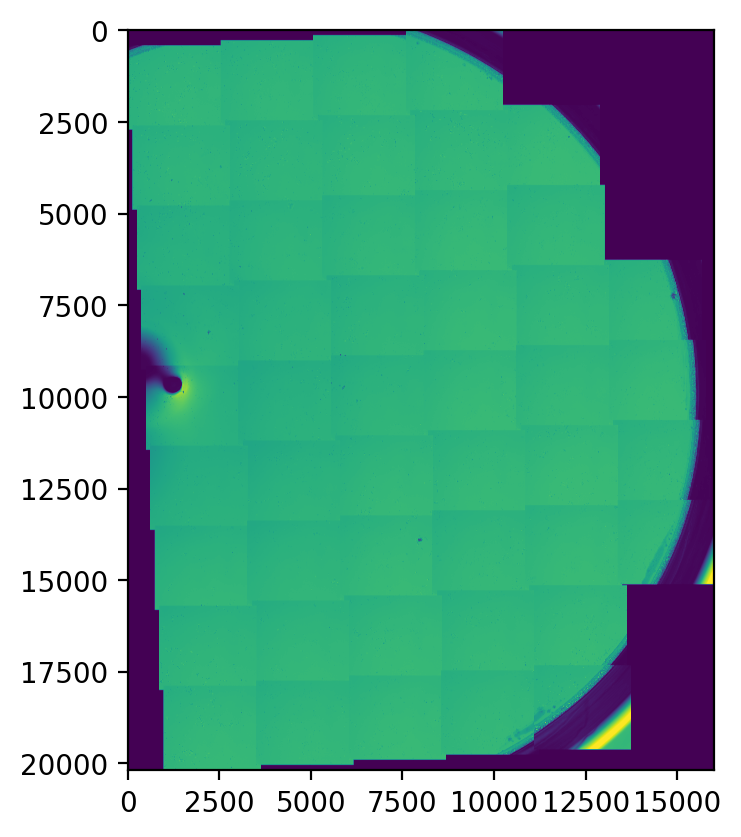

In [59]:
plt.imshow(mosaic)